In [1]:
import numpy as np
import pandas as pd
import datetime
import glob
import os.path
from pandas.compat import StringIO

### NREL Bird Model implementation: for obtaining clear sky GHI

In [2]:
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
%matplotlib inline
sns.set_color_codes()

In [4]:
import pvlib
from pvlib import clearsky, atmosphere
from pvlib.location import Location

In [5]:
ftp = Location(48,-106.449, 'US/Mountain', 630.0216, 'Fort Peck')

In [6]:
times2009 = pd.DatetimeIndex(start='2009-01-01', end='2010-01-01', freq='1min',
                        tz=ftp.tz)   # 12 months of 2009 - For testing
times2010and2011 = pd.DatetimeIndex(start='2010-01-01', end='2012-01-01', freq='1min',
                        tz=ftp.tz)   # 24 months of 2010 and 2011 - For training

In [7]:
cs_2009 = ftp.get_clearsky(times2009) 
cs_2010and2011 = ftp.get_clearsky(times2010and2011) # ineichen with climatology table by default
#cs_2011 = bvl.get_clearsky(times2011) 

In [8]:
cs_2009.drop(['dni','dhi'],axis=1, inplace=True) #updating the same dataframe by dropping two columns
cs_2010and2011.drop(['dni','dhi'],axis=1, inplace=True) #updating the same dataframe by dropping two columns
#cs_2011.drop(['dni','dhi'],axis=1, inplace=True) #updating the same dataframe by dropping two columns

In [9]:
cs_2009.reset_index(inplace=True)
cs_2010and2011.reset_index(inplace=True)
#cs_2011.reset_index(inplace=True)

In [10]:
cs_2009['index']=cs_2009['index'].apply(lambda x:x.to_datetime())
cs_2009['year'] = cs_2009['index'].apply(lambda x:x.year)
cs_2009['month'] = cs_2009['index'].apply(lambda x:x.month)
cs_2009['day'] = cs_2009['index'].apply(lambda x:x.day)
cs_2009['hour'] = cs_2009['index'].apply(lambda x:x.hour)
cs_2009['min'] = cs_2009['index'].apply(lambda x:x.minute)

In [11]:
cs_2010and2011['index']=cs_2010and2011['index'].apply(lambda x:x.to_datetime())
cs_2010and2011['year'] = cs_2010and2011['index'].apply(lambda x:x.year)
cs_2010and2011['month'] = cs_2010and2011['index'].apply(lambda x:x.month)
cs_2010and2011['day'] = cs_2010and2011['index'].apply(lambda x:x.day)
cs_2010and2011['hour'] = cs_2010and2011['index'].apply(lambda x:x.hour)
cs_2010and2011['min'] = cs_2010and2011['index'].apply(lambda x:x.minute)

In [12]:
print(cs_2009.shape)
print(cs_2010and2011.shape)
#print(cs_2011.shape)

(525601, 7)
(1051201, 7)


In [13]:
cs_2009.drop(cs_2009.index[-1], inplace=True)
cs_2010and2011.drop(cs_2010and2011.index[-1], inplace=True)
#cs_2011.drop(cs_2011.index[-1], inplace=True)

In [14]:
print(cs_2009.shape)
print(cs_2010and2011.shape)
#print(cs_2011.shape)

(525600, 7)
(1051200, 7)


In [15]:
cs_2010and2011.head()

,index,ghi,year,month,day,hour,min
0,2010-01-01 00:00:00-07:00,0.0,2010,1,1,0,0
1,2010-01-01 00:01:00-07:00,0.0,2010,1,1,0,1
2,2010-01-01 00:02:00-07:00,0.0,2010,1,1,0,2
3,2010-01-01 00:03:00-07:00,0.0,2010,1,1,0,3
4,2010-01-01 00:04:00-07:00,0.0,2010,1,1,0,4


### Import files from each year in a separate dataframe


- year            integer	 year, i.e., 1995
- jday            integer	 Julian day (1 through 365 [or 366])
- month           integer	 number of the month (1-12)
- day             integer	 day of the month(1-31)
- hour            integer	 hour of the day (0-23)
- min             integer	 minute of the hour (0-59)
- dt              real	 decimal time (hour.decimalminutes, e.g., 23.5 = 2330)
- zen             real	 solar zenith angle (degrees)
- dw_solar        real	 downwelling global solar (Watts m^-2)
- uw_solar        real	 upwelling global solar (Watts m^-2)
- direct_n        real	 direct-normal solar (Watts m^-2)
- diffuse         real	 downwelling diffuse solar (Watts m^-2)
- dw_ir           real	 downwelling thermal infrared (Watts m^-2)
- dw_casetemp     real	 downwelling IR case temp. (K)
- dw_dometemp     real	 downwelling IR dome temp. (K)
- uw_ir           real	 upwelling thermal infrared (Watts m^-2)
- uw_casetemp     real	 upwelling IR case temp. (K)
- uw_dometemp     real	 upwelling IR dome temp. (K)
- uvb             real	 global UVB (milliWatts m^-2)
- par             real	 photosynthetically active radiation (Watts m^-2)
- netsolar        real	 net solar (dw_solar - uw_solar) (Watts m^-2)
- netir           real	 net infrared (dw_ir - uw_ir) (Watts m^-2)
- totalnet        real	 net radiation (netsolar+netir) (Watts m^-2)
- temp            real	 10-meter air temperature (?C)
- rh              real	 relative humidity (%)
- windspd         real	 wind speed (ms^-1)
- winddir         real	 wind direction (degrees, clockwise from north)
- pressure        real	 station pressure (mb)


In [16]:
cols = ['year', 'jday', 'month', 'day','hour','min','dt','zen','dw_solar','dw_solar_QC','uw_solar',
       'uw_solar_QC', 'direct_n','direct_n_QC','diffuse', 'diffuse_QC', 'dw_ir', 'dw_ir_QC', 'dw_casetemp',
       'dw_casetemp_QC', 'dw_dometemp','dw_dometemp_QC','uw_ir', 'uw_ir_QC', 'uw_casetemp','uw_casetemp_QC',
       'uw_dometemp','uw_dometemp_QC','uvb','uvb_QC','par','par_QC','netsolar','netsolar_QC','netir','netir_QC',
       'totalnet','totalnet_QC','temp','temp_QC','rh','rh_QC','windspd','windspd_QC','winddir','winddir_QC',
       'pressure','pressure_QC']

In [17]:
path = r'.\\data\\Fort_Peck\\Exp_1_train'
all_files = glob.glob(path + "/*.dat")
all_files.sort()

df_big_train = pd.concat([pd.read_csv(f, skipinitialspace = True, quotechar = '"',skiprows=(2),delimiter=' ', 
                 index_col=False,header=None, names=cols) for f in all_files],ignore_index=True)
df_big_train.shape

(1050071, 48)

In [18]:
path = r'.\\data\\Fort_Peck\\Exp_1_test'
all_files = glob.glob(path + "/*.dat")
all_files.sort()

df_big_test = pd.concat((pd.read_csv(f, skipinitialspace = True, quotechar = '"',skiprows=(2),delimiter=' ', 
                 index_col=False,header=None, names=cols) for f in all_files),ignore_index=True)
df_big_test.shape

(524996, 48)

In [19]:
df_big_test[df_big_test['dw_solar']==-9999.9].shape

(39, 48)

### Merging Clear Sky GHI And the big dataframe

In [21]:
df_train = pd.merge(df_big_train, cs_2010and2011, on=['year','month','day','hour','min'])
df_train.shape

(1050071, 50)

In [22]:
df_test = pd.merge(df_big_test, cs_2009, on=['year','month','day','hour','min'])
df_test.shape

(524996, 50)

In [23]:
df_train.drop(['index'],axis=1, inplace=True) #updating the same dataframe by dropping the index columns from clear sky model
df_test.drop(['index'], axis=1, inplace=True)

In [24]:
df_train.shape

(1050071, 49)

### Managing missing values

In [25]:
# Resetting index
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [26]:
# Dropping rows with two or more -9999.9 values in columns

In [27]:
# Step1: Get indices of all rows with 2 or more -999
missing_data_indices = np.where((df_train <=-9999.9).apply(sum, axis=1)>=2)[0]
# Step2: Drop those indices
df_train.drop(missing_data_indices, axis=0, inplace=True)
# Checking that the rows are dropped
df_train.shape

(1025624, 49)

In [28]:
missing_data_indices_test = np.where((df_test <= -9999.9).apply(sum, axis=1)>=2)[0]
df_test.drop(missing_data_indices_test, axis=0, inplace=True)
df_test.shape

(466023, 49)

In [29]:
# For the rows with only one cell as -9999.9, replacing this cell with the mean of the column

#### First resetting index after dropping rows in the previous part of the code

In [30]:
# 2nd time - Reseting Index
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [31]:
one_miss_train_idx = np.where((df_train <=-9999.9).apply(sum, axis=1)==1)[0]

In [32]:
len(one_miss_train_idx)

14044

In [33]:
df_train.shape

(1025624, 49)

In [34]:
col_names = df_train.columns
from collections import defaultdict
stats = defaultdict(int)
total_single_missing_values = 0
for name in col_names:
    col_mean = df_train[~(df_train[name] == -9999.9)][name].mean()
    missing_indices = np.where((df_train[name] == -9999.9))
    stats[name] = len(missing_indices[0])
    df_train[name].loc[missing_indices] = col_mean
    total_single_missing_values += sum(df_train[name] == -9999.9)
    

C:\Users\s269596\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [35]:
df_col_min = df_train.apply(min, axis=0)
df_col_max = df_train.apply(max, axis =0)
#print(df_col_min, df_col_max)

In [36]:
train = np.where((df_train <=-9999.9).apply(sum, axis=1)==1)[0]

In [37]:
len(train)

0

In [38]:
# doing the same thing on test dataset

In [39]:
one_miss_test_idx = np.where((df_test <=-9999.9).apply(sum, axis=1)==1)[0]
len(one_miss_test_idx)

556

In [40]:
col_names_test = df_test.columns
from collections import defaultdict
stats_test = defaultdict(int)
total_single_missing_values_test = 0
for name in col_names_test:
    col_mean = df_test[~(df_test[name] == -9999.9)][name].mean()
    missing_indices = np.where((df_test[name] == -9999.9))
    stats_test[name] = len(missing_indices[0])
    df_test[name].loc[missing_indices] = col_mean
    total_single_missing_values_test += sum(df_test[name] == -9999.9)
    

C:\Users\s269596\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [41]:
test = np.where((df_test <=-9999.9).apply(sum, axis=1)==1)[0]

In [42]:
len(test)

0

In [43]:
df_train.shape

(1025624, 49)

In [44]:
df_test.shape

(466023, 49)

### Exploratory Data Analysis

In [45]:
dw_solar_everyday = df_test.groupby(['jday'])['dw_solar'].mean()
ghi_everyday = df_test.groupby(['jday'])['ghi'].mean()
j_day = df_test['jday'].unique()

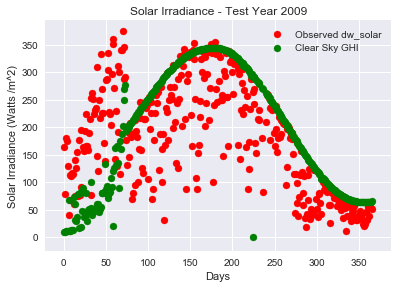

In [46]:
fig = plt.figure()

axes1 = fig.add_axes([0.1,0.1,0.8,0.8])
#axes2 = fig.add_axes([0.1,0.1,0.8,0.8])

axes1.scatter(j_day,dw_solar_everyday,label='Observed dw_solar',color='red')
axes1.scatter(j_day, ghi_everyday, label='Clear Sky GHI',color='green')

axes1.set_xlabel('Days')
axes1.set_ylabel('Solar Irradiance (Watts /m^2)')
axes1.set_title('Solar Irradiance - Test Year 2009')
axes1.legend(loc='best')

fig.savefig('Figure2.png', bbox_inches = 'tight')

C:\Users\s269596\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


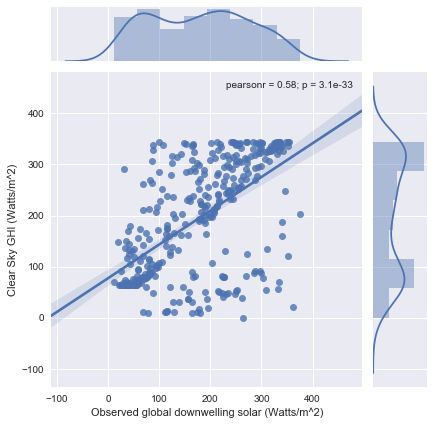

In [47]:
sns.jointplot(x=dw_solar_everyday,y=ghi_everyday,kind='reg')
#plt.title('observed dw_solar vs clear sky ghi')
plt.xlabel('Observed global downwelling solar (Watts/m^2)')
plt.ylabel('Clear Sky GHI (Watts/m^2)')
plt.savefig('Figure3.png', bbox_inches='tight')

### making the Kt (clear sky index at time t) column by first removing rows with ghi==0

In [48]:
df_train = df_train[df_train['ghi']!=0]
df_test = df_test[df_test['ghi']!=0]
df_train['Kt'] = df_train['dw_solar']/df_train['ghi']
df_test['Kt'] = df_test['dw_solar']/df_test['ghi']

In [49]:
df_train.reset_index(inplace=True)
df_test.reset_index(inplace=True)

In [50]:
print("test Kt max: "+str(df_test['Kt'].max()))
print("test Kt min: "+str(df_test['Kt'].min()))
print("test Kt mean: "+str(df_test['Kt'].mean()))
print("\n")
print("train Kt max: "+str(df_train['Kt'].max()))
print("train Kt min: "+str(df_train['Kt'].min()))
print("train Kt mean: "+str(df_train['Kt'].mean()))

test Kt max: 6708504.1476219045
test Kt min: -760.2171477048815
test Kt mean: 32.49910713059261


train Kt max: 2638590.5112375193
train Kt min: -1423.5534672678295
train Kt mean: 8.408929323818732


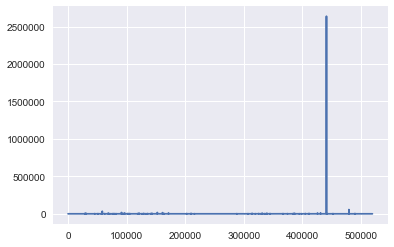

In [51]:
plt.plot(df_train['Kt'])

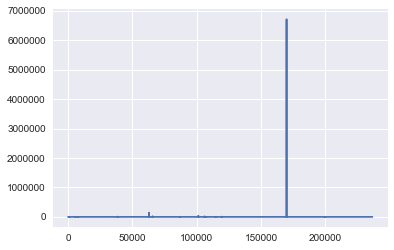

In [52]:
plt.plot(df_test['Kt'])

In [53]:
df_train= df_train[df_train['Kt']< 5000]
df_train= df_train[df_train['Kt']> -1000]
df_test= df_test[df_test['Kt']< 5000]
df_test= df_test[df_test['Kt']> -1000]

#### Group the data (train dataframe)

In [54]:
zen = df_train.groupby(['year','month','day','hour'])['zen'].mean()
dw_solar = df_train.groupby(['year','month','day','hour'])['dw_solar'].mean()
uw_solar = df_train.groupby(['year','month','day','hour'])['uw_solar'].mean()
direct_n = df_train.groupby(['year','month','day','hour'])['direct_n'].mean()
diffuse = df_train.groupby(['year','month','day','hour'])['diffuse'].mean()
dw_ir = df_train.groupby(['year','month','day','hour'])['dw_ir'].mean()
dw_casetemp = df_train.groupby(['year','month','day','hour'])['dw_casetemp'].mean()
dw_dometemp = df_train.groupby(['year','month','day','hour'])['dw_dometemp'].mean()
uw_ir = df_train.groupby(['year','month','day','hour'])['uw_ir'].mean()
uw_casetemp = df_train.groupby(['year','month','day','hour'])['uw_casetemp'].mean()
uw_dometemp = df_train.groupby(['year','month','day','hour'])['uw_dometemp'].mean()
uvb = df_train.groupby(['year','month','day','hour'])['uvb'].mean()
par = df_train.groupby(['year','month','day','hour'])['par'].mean()
netsolar = df_train.groupby(['year','month','day','hour'])['netsolar'].mean()
netir = df_train.groupby(['year','month','day','hour'])['netir'].mean()
totalnet = df_train.groupby(['year','month','day','hour'])['totalnet'].mean()
temp = df_train.groupby(['year','month','day','hour'])['temp'].mean()
rh = df_train.groupby(['year','month','day','hour'])['rh'].mean()
windspd = df_train.groupby(['year','month','day','hour'])['windspd'].mean()
winddir = df_train.groupby(['year','month','day','hour'])['winddir'].mean()
pressure = df_train.groupby(['year','month','day','hour'])['pressure'].mean()
ghi = df_train.groupby(['year','month','day','hour'])['ghi'].mean()
Kt = df_train.groupby(['year','month','day','hour'])['Kt'].mean()

In [55]:
df_new_train = pd.concat([zen,dw_solar,uw_solar,direct_n,diffuse,dw_ir,dw_casetemp,dw_dometemp,uw_ir,uw_casetemp,uw_dometemp,
                    uvb,par,netsolar,netir,totalnet,temp,rh,windspd,winddir,pressure,ghi,Kt], axis=1)

In [56]:
df_new_train.head()

zen  dw_solar  uw_solar  direct_n   diffuse  \
year   month day hour                                                       
2010.0 1.0   1.0 7.0   152.500000 -2.550000  0.500000  0.100000  0.500000   
                 8.0   149.438333 -2.245000  0.513333  1.445000  0.243333   
                 9.0   141.688000 -2.595000 -0.056667  1.825000  0.251667   
                 10.0  132.410667 -2.341667  0.215000  1.508333  0.281667   
                 11.0  122.550500 -2.611667  0.143333  1.915000  0.248333   

                            dw_ir  dw_casetemp  dw_dometemp       uw_ir  \
year   month day hour                                                     
2010.0 1.0   1.0 7.0   152.500000   248.050000   247.800000  195.450000   
                 8.0   149.576667   246.816667   246.593333  190.816667   
                 9.0   148.300000   244.931667   244.778333  187.660000   
                 10.0  147.040000   243.778333   243.615000  184.533333   
                 11.0  146.465000   243.041667   242.920000  182.806667   

                       uw_casetemp    ...     netsolar      netir   totalnet  \
year   month day hour                 ...                                      
2010.0 1.0   1.0 7.0    247.250000    ...          0.0 -42.950000 -42.950000   
                 8.0    245.775000    ...          0.0 -41.231667 -41.231667   
                 9.0    244.426667    ...          0.0 -39.358333 -39.358333   
                 10.0   243.090000    ...          0.0 -37.488333 -37.488333   
                 11.0   242.098333    ...          0.0 -36.341667 -36.341667   

                            temp         rh   windspd     winddir    pressure  \
year   month day hour                                                           
2010.0 1.0   1.0 7.0  -25.900000  80.250000  4.250000  348.000000  958.950000   
                 8.0  -27.401667  80.756667  3.488333  315.585000  959.703333   
                 9.0  -28.131667  80.201667  3.893333  341.580000  960.186667   
                 10.0 -29.798333  79.325000  3.816667  341.220000  960.108333   
                 11.0 -30.808333  78.328333  3.310000  304.276667  959.655000   

                              ghi        Kt  
year   month day hour                        
2010.0 1.0   1.0 7.0     5.054489 -2.210247  
                 8.0    47.742733 -0.062791  
                 9.0   147.117239 -0.018213  
                 10.0  240.573050 -0.009789  
                 11.0  295.936982 -0.008846  

[5 rows x 23 columns]

#### Groupdata - test dataframe

In [57]:
test_zen = df_test.groupby(['month','day','hour'])['zen'].mean()
test_dw_solar = df_test.groupby(['month','day','hour'])['dw_solar'].mean()
test_uw_solar = df_test.groupby(['month','day','hour'])['uw_solar'].mean()
test_direct_n = df_test.groupby(['month','day','hour'])['direct_n'].mean()
test_diffuse = df_test.groupby(['month','day','hour'])['diffuse'].mean()
test_dw_ir = df_test.groupby(['month','day','hour'])['dw_ir'].mean()
test_dw_casetemp = df_test.groupby(['month','day','hour'])['dw_casetemp'].mean()
test_dw_dometemp = df_test.groupby(['month','day','hour'])['dw_dometemp'].mean()
test_uw_ir = df_test.groupby(['month','day','hour'])['uw_ir'].mean()
test_uw_casetemp = df_test.groupby(['month','day','hour'])['uw_casetemp'].mean()
test_uw_dometemp = df_test.groupby(['month','day','hour'])['uw_dometemp'].mean()
test_uvb = df_test.groupby(['month','day','hour'])['uvb'].mean()
test_par = df_test.groupby(['month','day','hour'])['par'].mean()
test_netsolar = df_test.groupby(['month','day','hour'])['netsolar'].mean()
test_netir = df_test.groupby(['month','day','hour'])['netir'].mean()
test_totalnet = df_test.groupby(['month','day','hour'])['totalnet'].mean()
test_temp = df_test.groupby(['month','day','hour'])['temp'].mean()
test_rh = df_test.groupby(['month','day','hour'])['rh'].mean()
test_windspd = df_test.groupby(['month','day','hour'])['windspd'].mean()
test_winddir = df_test.groupby(['month','day','hour'])['winddir'].mean()
test_pressure = df_test.groupby(['month','day','hour'])['pressure'].mean()
test_ghi = df_test.groupby(['month','day','hour'])['ghi'].mean()
test_Kt = df_test.groupby(['month','day','hour'])['Kt'].mean()

In [58]:
df_new_test = pd.concat([test_zen,test_dw_solar,test_uw_solar,test_direct_n,test_diffuse,test_dw_ir,
                         test_dw_casetemp,test_dw_dometemp,test_uw_ir,test_uw_casetemp,test_uw_dometemp,
                    test_uvb,test_par,test_netsolar,test_netir,test_totalnet,test_temp,test_rh,
                         test_windspd,test_winddir,test_pressure,test_ghi,test_Kt], axis=1)

In [59]:
df_new_test.loc[2].xs(17,level='day')

,zen,dw_solar,uw_solar,direct_n,diffuse,dw_ir,dw_casetemp,dw_dometemp,uw_ir,uw_casetemp,...,netsolar,netir,totalnet,temp,rh,windspd,winddir,pressure,ghi,Kt
hour,,,,,,,,,,,,,,,,,,,,,
13.0,93.876897,-5.324138,0.296552,3.444828,0.796552,263.427586,264.431034,264.241379,268.458621,261.768966,...,0.389655,-5.044828,-4.658621,-11.031034,93.793103,3.441379,186.258621,933.775862,454.397482,-0.011699
14.0,86.859792,11.529167,15.887500,2.856250,19.741667,266.177083,265.522917,265.304167,271.779167,262.820833,...,4.114583,-5.600000,0.353241,-10.216667,94.195833,4.133333,11.343750,933.754167,387.795068,0.033291
15.0,77.951000,82.070000,76.600000,2.671667,99.445000,266.750000,266.643333,266.485000,274.400000,263.601667,...,23.411667,-7.645000,15.760000,-9.826667,94.228333,4.073333,167.686667,934.028333,258.552442,0.342809
16.0,70.364167,170.833333,151.813333,3.088333,196.435000,270.118333,268.296667,268.248333,278.895000,264.901667,...,45.646667,-8.785000,36.868333,-8.786667,94.641667,2.905000,339.636667,934.480000,112.367516,1.876063
17.0,65.665161,257.512903,223.258065,4.993548,288.264516,272.490323,269.638710,269.654839,282.845161,265.922581,...,67.074194,-10.354839,56.725806,-8.000000,95.009677,3.212903,325.225806,934.738710,24.827779,44.603082


### Shifting Kt values to make 1 hour ahead forecast

#### Train dataset

In [60]:
levels_index= []
for m in df_new_train.index.levels:
    levels_index.append(m)

In [61]:
for i in levels_index[0]:
    for j in levels_index[1]:
        df_new_train.loc[i].loc[j]['Kt'] = df_new_train.loc[i].loc[j]['Kt'].shift(-1)

In [62]:
df_new_train = df_new_train[~(df_new_train['Kt'].isnull())]

#### Test dataset

In [63]:
levels_index2= []
for m in df_new_test.index.levels:
    levels_index2.append(m)

In [64]:
for i in levels_index2[0]:
    for j in levels_index2[1]:
        df_new_test.loc[i].loc[j]['Kt'] = df_new_test.loc[i].loc[j]['Kt'].shift(-1)

In [65]:
df_new_test = df_new_test[~(df_new_test['Kt'].isnull())]

In [66]:
df_new_test[df_new_test['Kt']==df_new_test['Kt'].max()]

,,,zen,dw_solar,uw_solar,direct_n,diffuse,dw_ir,dw_casetemp,dw_dometemp,uw_ir,uw_casetemp,...,netsolar,netir,totalnet,temp,rh,windspd,winddir,pressure,ghi,Kt
month,day,hour,,,,,,,,,,,,,,,,,,,,,
7.0,13.0,20.0,31.445,786.088333,85.93,472.386667,389.726667,466.295,304.083333,303.981667,500.005,298.88,...,702.756667,-33.708333,669.046667,24.815,65.396667,8.685,121.041667,936.996667,35.047437,1801.738697


### Normalize train and test dataframe

In [67]:
train_norm = (df_new_train - df_new_train.mean()) / (df_new_train.max() - df_new_train.min())
test_norm =  (df_new_test - df_new_test.mean()) / (df_new_test.max() - df_new_test.min())

In [68]:
train_norm.reset_index(inplace=True,drop=True)
test_norm.reset_index(inplace=True,drop=True)

### Making train and test sets with train_norm and test_norm

#### finding the gcf (greatest common factor) of train and test dataset's length and chop off the extra rows to make it divisible with the batchsize

In [69]:
from fractions import gcd
gcd(train_norm.shape[0],test_norm.shape[0])

C:\Users\s269596\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: fractions.gcd() is deprecated. Use math.gcd() instead.
  


1

In [70]:
import math
def roundup(x):
    return int(math.ceil(x / 100.0)) * 100

In [71]:
train_lim = roundup(train_norm.shape[0])
test_lim = roundup(test_norm.shape[0])

train_random = train_norm.sample(train_lim-train_norm.shape[0])
test_random = test_norm.sample(test_lim-test_norm.shape[0])

train_norm = train_norm.append(train_random)
test_norm = test_norm.append(test_random)

In [72]:
X1 = train_norm.drop('Kt',axis=1)
y1 = train_norm['Kt']

X2 = test_norm.drop('Kt',axis=1)
y2 = test_norm['Kt']

In [73]:
print("X1_train shape is {}".format(X1.shape))
print("y1_train shape is {}".format(y1.shape))
print("X2_test shape is {}".format(X2.shape))
print("y2_test shape is {}".format(y2.shape))

X1_train shape is (9600, 22)
y1_train shape is (9600,)
X2_test shape is (4000, 22)
y2_test shape is (4000,)


In [74]:
X_train = np.array(X1)
y_train  = np.array(y1)
X_test = np.array(X2)
y_test = np.array(y2)

### start of RNN

In [75]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable

In [76]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        #Hidden Dimension
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        #Building the RNN
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu')
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # Initializing the hidden state with zeros
        # (layer_dim, batch_size, hidden_dim)
        h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
        
        #One time step (the last one perhaps?)
        out, hn = self.rnn(x, h0)
        
        # Indexing hidden state of the last time step
        # out.size() --> ??
        #out[:,-1,:] --> is it going to be 100,100
        out = self.fc(out[:,-1,:])
        # out.size() --> 100,1
        return out
        

In [77]:
# Instantiating Model Class
input_dim = 22
hidden_dim = 15
layer_dim = 1
output_dim = 1
batch_size = 100

model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)

# Instantiating Loss Class
criterion = nn.MSELoss()

# Instantiate Optimizer Class
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# converting numpy array to torch tensor
X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train)
X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(y_test)

# initializing lists to store losses over epochs:
train_loss = []
test_loss = []
train_iter = []
test_iter = []

In [78]:
# Training the model
seq_dim = 1

n_iter =0
num_samples = len(X_train)
test_samples = len(X_test)
batch_size = 100
num_epochs = 1000
feat_dim = X_train.shape[1]

X_train = X_train.type(torch.FloatTensor)
y_train = y_train.type(torch.FloatTensor)
X_test = X_test.type(torch.FloatTensor)
y_test = y_test.type(torch.FloatTensor)

for epoch in range(num_epochs):
    for i in range(0, int(num_samples/batch_size -1)):
        
        
        features = Variable(X_train[i*batch_size:(i+1)*batch_size, :]).view(-1, seq_dim, feat_dim)
        Kt_value = Variable(y_train[i*batch_size:(i+1)*batch_size])
        
        #print("Kt_value={}".format(Kt_value))
        
        optimizer.zero_grad()
        
        outputs = model(features)
        #print("outputs ={}".format(outputs))
        
        loss = criterion(outputs, Kt_value)
        
        train_loss.append(loss.data[0])
        train_iter.append(n_iter)

        #print("loss = {}".format(loss))
        loss.backward()
        
        optimizer.step()
        
        n_iter += 1  
            
        if n_iter%100 == 0:
            for i in range(0,int(test_samples/batch_size -1)):
                features = Variable(X_test[i*batch_size:(i+1)*batch_size, :]).view(-1, seq_dim, feat_dim)
                Kt_test = Variable(y_test[i*batch_size:(i+1)*batch_size])
                
                outputs = model(features)
                
                mse = np.sqrt(np.mean((Kt_test.data.numpy() - outputs.data.numpy().squeeze())**2)/num_samples)
                
                test_iter.append(n_iter)
                test_loss.append(mse)
                
            print('Epoch: {} Iteration: {}. Train_MSE: {}. Test_MSE: {}'.format(epoch, n_iter, loss.data[0], mse))
               

Epoch: 1 Iteration: 100. Train_MSE: 0.016373340040445328. Test_MSE: 0.0014411520359023933
Epoch: 2 Iteration: 200. Train_MSE: 0.00756833516061306. Test_MSE: 0.0011842864718703654
Epoch: 3 Iteration: 300. Train_MSE: 0.003676122985780239. Test_MSE: 0.0009975860032243212
Epoch: 4 Iteration: 400. Train_MSE: 0.012392270378768444. Test_MSE: 0.0008603397173540615
Epoch: 5 Iteration: 500. Train_MSE: 0.003630056045949459. Test_MSE: 0.0007583133955809219
Epoch: 6 Iteration: 600. Train_MSE: 0.004392724484205246. Test_MSE: 0.0006812579404680961
Epoch: 7 Iteration: 700. Train_MSE: 0.002360597951337695. Test_MSE: 0.0006194336421992494
Epoch: 8 Iteration: 800. Train_MSE: 0.0020085936412215233. Test_MSE: 0.0005680213603947479
Epoch: 9 Iteration: 900. Train_MSE: 0.002799925860017538. Test_MSE: 0.0005225318417907286
Epoch: 10 Iteration: 1000. Train_MSE: 0.001483799540437758. Test_MSE: 0.0004839303461001353
Epoch: 11 Iteration: 1100. Train_MSE: 0.0016926635289564729. Test_MSE: 0.0004527805957272085
Epoch

Epoch: 93 Iteration: 8900. Train_MSE: 0.0007604020647704601. Test_MSE: 0.00017212194892495127
Epoch: 94 Iteration: 9000. Train_MSE: 0.0007141305250115693. Test_MSE: 0.0001720789757240079
Epoch: 95 Iteration: 9100. Train_MSE: 0.0009403813164681196. Test_MSE: 0.00017202020159186326
Epoch: 96 Iteration: 9200. Train_MSE: 0.0005680472240783274. Test_MSE: 0.00017191402069575385
Epoch: 97 Iteration: 9300. Train_MSE: 0.000617766345385462. Test_MSE: 0.00017179071887132456
Epoch: 98 Iteration: 9400. Train_MSE: 0.00014223172911442816. Test_MSE: 0.0001717333554432221
Epoch: 99 Iteration: 9500. Train_MSE: 0.0002349470159970224. Test_MSE: 0.00017169876044786665
Epoch: 101 Iteration: 9600. Train_MSE: 0.00021672490402124822. Test_MSE: 0.0001716580037386041
Epoch: 102 Iteration: 9700. Train_MSE: 0.0006240882212296128. Test_MSE: 0.00017166023783835648
Epoch: 103 Iteration: 9800. Train_MSE: 0.0005046927253715694. Test_MSE: 0.00017168662980441947
Epoch: 104 Iteration: 9900. Train_MSE: 0.009715665131807327

Epoch: 185 Iteration: 17600. Train_MSE: 0.00042809639126062393. Test_MSE: 0.000167867702554732
Epoch: 186 Iteration: 17700. Train_MSE: 0.0003953626146540046. Test_MSE: 0.00016770794220901845
Epoch: 187 Iteration: 17800. Train_MSE: 0.000297139777103439. Test_MSE: 0.00016761160956158588
Epoch: 188 Iteration: 17900. Train_MSE: 0.00031536075402982533. Test_MSE: 0.00016747496727836448
Epoch: 189 Iteration: 18000. Train_MSE: 0.00013788542128168046. Test_MSE: 0.0001673776673664164
Epoch: 190 Iteration: 18100. Train_MSE: 0.0002148493513232097. Test_MSE: 0.0001671980477002605
Epoch: 191 Iteration: 18200. Train_MSE: 0.00042392744217067957. Test_MSE: 0.00016714454949427374
Epoch: 192 Iteration: 18300. Train_MSE: 0.00035469623981043696. Test_MSE: 0.0001670663296905327
Epoch: 193 Iteration: 18400. Train_MSE: 0.0006098637823015451. Test_MSE: 0.0001672271834202908
Epoch: 194 Iteration: 18500. Train_MSE: 0.0005660930182784796. Test_MSE: 0.0001672204846484671
Epoch: 195 Iteration: 18600. Train_MSE: 0.0

Epoch: 275 Iteration: 26200. Train_MSE: 0.0005325271049514413. Test_MSE: 0.00016189338048359965
Epoch: 276 Iteration: 26300. Train_MSE: 0.0003396110550966114. Test_MSE: 0.000161717839477699
Epoch: 277 Iteration: 26400. Train_MSE: 0.00041863671503961086. Test_MSE: 0.00016146097668556016
Epoch: 278 Iteration: 26500. Train_MSE: 0.00012979141320101917. Test_MSE: 0.00016133463747697673
Epoch: 279 Iteration: 26600. Train_MSE: 0.00018267407722305506. Test_MSE: 0.00016118709776849618
Epoch: 281 Iteration: 26700. Train_MSE: 0.00017790106358006597. Test_MSE: 0.00016108798537788123
Epoch: 282 Iteration: 26800. Train_MSE: 0.0004873759171459824. Test_MSE: 0.00016113881913643095
Epoch: 283 Iteration: 26900. Train_MSE: 0.00034662566031329334. Test_MSE: 0.00016124816602778504
Epoch: 284 Iteration: 27000. Train_MSE: 0.009410766884684563. Test_MSE: 0.000161329808102032
Epoch: 285 Iteration: 27100. Train_MSE: 0.00032282975735142827. Test_MSE: 0.00016129025628218397
Epoch: 286 Iteration: 27200. Train_MSE:

Epoch: 366 Iteration: 34800. Train_MSE: 0.000265462149400264. Test_MSE: 0.0001559154407930741
Epoch: 367 Iteration: 34900. Train_MSE: 0.00019938143668696284. Test_MSE: 0.0001558165016823859
Epoch: 368 Iteration: 35000. Train_MSE: 0.0002507070021238178. Test_MSE: 0.00015562818483445934
Epoch: 369 Iteration: 35100. Train_MSE: 0.00010783277684822679. Test_MSE: 0.0001554872557193054
Epoch: 370 Iteration: 35200. Train_MSE: 0.00017092823691200465. Test_MSE: 0.00015527133901495593
Epoch: 371 Iteration: 35300. Train_MSE: 0.00038035830948501825. Test_MSE: 0.00015524507099372583
Epoch: 372 Iteration: 35400. Train_MSE: 0.00026983433053828776. Test_MSE: 0.00015518108358804643
Epoch: 373 Iteration: 35500. Train_MSE: 0.00044900455395691097. Test_MSE: 0.00015535289728362087
Epoch: 374 Iteration: 35600. Train_MSE: 0.0004494139284361154. Test_MSE: 0.00015537291309089524
Epoch: 375 Iteration: 35700. Train_MSE: 0.00044113557669334114. Test_MSE: 0.00015536327382342663
Epoch: 376 Iteration: 35800. Train_MS

Epoch: 456 Iteration: 43400. Train_MSE: 0.00025976038887165487. Test_MSE: 0.00015024106504647484
Epoch: 457 Iteration: 43500. Train_MSE: 0.0003461555461399257. Test_MSE: 0.00014998735256414487
Epoch: 458 Iteration: 43600. Train_MSE: 0.0001158412269433029. Test_MSE: 0.00014983563511959338
Epoch: 459 Iteration: 43700. Train_MSE: 0.00015682425873819739. Test_MSE: 0.00014966237446827532
Epoch: 461 Iteration: 43800. Train_MSE: 0.00015371470362879336. Test_MSE: 0.0001495799327707319
Epoch: 462 Iteration: 43900. Train_MSE: 0.0003949011443182826. Test_MSE: 0.00014963603858718962
Epoch: 463 Iteration: 44000. Train_MSE: 0.0002828189462888986. Test_MSE: 0.00014974881981127673
Epoch: 464 Iteration: 44100. Train_MSE: 0.009337179362773895. Test_MSE: 0.00014985243276258894
Epoch: 465 Iteration: 44200. Train_MSE: 0.00023499382950831205. Test_MSE: 0.00014983927704488584
Epoch: 466 Iteration: 44300. Train_MSE: 0.0002298802137374878. Test_MSE: 0.0001497186265690081
Epoch: 467 Iteration: 44400. Train_MSE:

Epoch: 548 Iteration: 52100. Train_MSE: 0.00022337341215461493. Test_MSE: 0.00014479926423687655
Epoch: 549 Iteration: 52200. Train_MSE: 8.792056905804202e-05. Test_MSE: 0.0001446664109456678
Epoch: 550 Iteration: 52300. Train_MSE: 0.0001431565615348518. Test_MSE: 0.0001444805153611588
Epoch: 551 Iteration: 52400. Train_MSE: 0.0003476002311799675. Test_MSE: 0.00014447875801590197
Epoch: 552 Iteration: 52500. Train_MSE: 0.00022238444944377989. Test_MSE: 0.00014442736588614748
Epoch: 553 Iteration: 52600. Train_MSE: 0.0003579930926207453. Test_MSE: 0.00014457336197187524
Epoch: 554 Iteration: 52700. Train_MSE: 0.00039764828397892416. Test_MSE: 0.00014460120695073938
Epoch: 555 Iteration: 52800. Train_MSE: 0.00034346897155046463. Test_MSE: 0.00014460084005252306
Epoch: 556 Iteration: 52900. Train_MSE: 0.00023436105402652174. Test_MSE: 0.00014445256841572187
Epoch: 557 Iteration: 53000. Train_MSE: 0.00032105448190122843. Test_MSE: 0.00014421045177635727
Epoch: 558 Iteration: 53100. Train_M

Epoch: 638 Iteration: 60700. Train_MSE: 0.00010322277375962585. Test_MSE: 0.00013981410285253938
Epoch: 639 Iteration: 60800. Train_MSE: 0.00013695012603420764. Test_MSE: 0.00013964783846508828
Epoch: 641 Iteration: 60900. Train_MSE: 0.00013465066149365157. Test_MSE: 0.00013959083463775784
Epoch: 642 Iteration: 61000. Train_MSE: 0.0003310455067548901. Test_MSE: 0.0001396408641962842
Epoch: 643 Iteration: 61100. Train_MSE: 0.00024505314650014043. Test_MSE: 0.00013974174279172464
Epoch: 644 Iteration: 61200. Train_MSE: 0.00934492889791727. Test_MSE: 0.00013984226678861374
Epoch: 645 Iteration: 61300. Train_MSE: 0.0001865663507487625. Test_MSE: 0.00013984606057279513
Epoch: 646 Iteration: 61400. Train_MSE: 0.0001895701716421172. Test_MSE: 0.00013975292593929338
Epoch: 647 Iteration: 61500. Train_MSE: 0.00013880946789868176. Test_MSE: 0.00013967059875269662
Epoch: 648 Iteration: 61600. Train_MSE: 0.00021450064377859235. Test_MSE: 0.00013948223442343394
Epoch: 649 Iteration: 61700. Train_MS

Epoch: 729 Iteration: 69300. Train_MSE: 7.426872616633773e-05. Test_MSE: 0.00013533028347646379
Epoch: 730 Iteration: 69400. Train_MSE: 0.00012284255353733897. Test_MSE: 0.0001351763736383762
Epoch: 731 Iteration: 69500. Train_MSE: 0.00032039821962825954. Test_MSE: 0.00013518562460724796
Epoch: 732 Iteration: 69600. Train_MSE: 0.00018979290325660259. Test_MSE: 0.00013514194325809343
Epoch: 733 Iteration: 69700. Train_MSE: 0.00029688762151636183. Test_MSE: 0.00013526297717563756
Epoch: 734 Iteration: 69800. Train_MSE: 0.0003664855321403593. Test_MSE: 0.00013529468225055731
Epoch: 735 Iteration: 69900. Train_MSE: 0.0002818310749717057. Test_MSE: 0.00013529876039904216
Epoch: 736 Iteration: 70000. Train_MSE: 0.00020293080888222903. Test_MSE: 0.00013516497445273084
Epoch: 737 Iteration: 70100. Train_MSE: 0.0002880275424104184. Test_MSE: 0.00013494170312011524
Epoch: 738 Iteration: 70200. Train_MSE: 9.72030611592345e-05. Test_MSE: 0.0001347882211395236
Epoch: 739 Iteration: 70300. Train_MSE

Epoch: 819 Iteration: 77900. Train_MSE: 0.00012089255324099213. Test_MSE: 0.0001309242827799344
Epoch: 821 Iteration: 78000. Train_MSE: 0.00012023980525555089. Test_MSE: 0.0001308872283479993
Epoch: 822 Iteration: 78100. Train_MSE: 0.0002825976407621056. Test_MSE: 0.00013093100356175444
Epoch: 823 Iteration: 78200. Train_MSE: 0.00021949122310616076. Test_MSE: 0.00013102159335881208
Epoch: 824 Iteration: 78300. Train_MSE: 0.009358217008411884. Test_MSE: 0.0001311177161065374
Epoch: 825 Iteration: 78400. Train_MSE: 0.00015630936832167208. Test_MSE: 0.00013113488853692907
Epoch: 826 Iteration: 78500. Train_MSE: 0.00016295835666824132. Test_MSE: 0.00013106122947538934
Epoch: 827 Iteration: 78600. Train_MSE: 0.0001165585417766124. Test_MSE: 0.0001309894904796374
Epoch: 828 Iteration: 78700. Train_MSE: 0.00020328258688095957. Test_MSE: 0.0001308116800810588
Epoch: 829 Iteration: 78800. Train_MSE: 6.862955342512578e-05. Test_MSE: 0.00013070247706908084
Epoch: 830 Iteration: 78900. Train_MSE: 

Epoch: 910 Iteration: 86500. Train_MSE: 0.00010792549437610433. Test_MSE: 0.0001272116164450775
Epoch: 911 Iteration: 86600. Train_MSE: 0.0002996674447786063. Test_MSE: 0.00012722615881249118
Epoch: 912 Iteration: 86700. Train_MSE: 0.00016525639512110502. Test_MSE: 0.0001271894630976463
Epoch: 913 Iteration: 86800. Train_MSE: 0.0002516693784855306. Test_MSE: 0.00012729530316810803
Epoch: 914 Iteration: 86900. Train_MSE: 0.0003454413381405175. Test_MSE: 0.0001273314148201278
Epoch: 915 Iteration: 87000. Train_MSE: 0.00024021808349061757. Test_MSE: 0.0001273417832699841
Epoch: 916 Iteration: 87100. Train_MSE: 0.00018090839148499072. Test_MSE: 0.0001272218695529157
Epoch: 917 Iteration: 87200. Train_MSE: 0.0002638628939166665. Test_MSE: 0.00012701704396483407
Epoch: 918 Iteration: 87300. Train_MSE: 8.820134826237336e-05. Test_MSE: 0.00012686894588814394
Epoch: 919 Iteration: 87400. Train_MSE: 0.00011354139860486612. Test_MSE: 0.00012672243910295198
Epoch: 921 Iteration: 87500. Train_MSE: 

37050


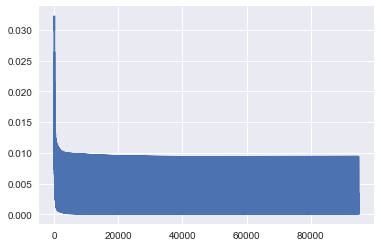

In [79]:
print(len(test_loss))
#plt.plot(test_loss)
plt.plot(train_loss,'-')
#plt.ylim([0.000,0.99])


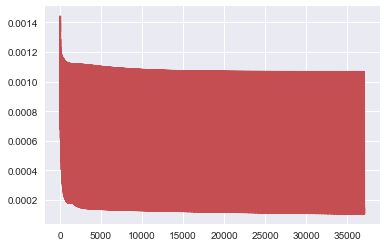

In [80]:
plt.plot(test_loss,'r')

#### Demornamization

In [81]:
rmse = np.sqrt(mse)

In [82]:
rmse_denorm = (rmse * (df_new_test['Kt'].max() - df_new_test['Kt'].min()))+ df_new_test['Kt'].mean()

In [83]:
rmse_denorm

28.40179473080549

In [84]:
df_new_test['Kt'].describe()

count    3941.000000
mean        8.365886
std        50.266729
min        -0.486594
25%        -0.012258
50%         0.097332
75%         1.286577
max      1801.738697
Name: Kt, dtype: float64

### Saving train and test losses to a csv

In [85]:
df_trainLoss = pd.DataFrame(data={'Train Loss':train_loss}, columns=['Train Loss'])
df_trainLoss.to_csv('RNN Paper Results/Exp1_FortPeck_TrainLoss.csv')
df_testLoss = pd.DataFrame(data={'Test Loss':test_loss}, columns=['Test Loss'])
df_testLoss.to_csv('RNN Paper Results/Exp1_FortPeck_TestLoss.csv')